# Ensembles

This script runs the ensemble methods (hard voting, soft voting, stacking) using the three learners (Bernoulli Naive Bayes, LSTM, mBERT).

## Imports

In [1]:
import torch
import joblib
from sklearn.naive_bayes import BernoulliNB
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np
from torch import Tensor, nn, LongTensor
import calamancy
from transformers import (
  BertForSequenceClassification,
  BertTokenizer
)
import numpy as np
import pandas as pd
import torch
import math
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

/tmp/ipykernel_18380/3723750217.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/home/nate/miniconda3/lib/python3.9/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/home/nate/miniconda3/lib/python3.9/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(

## Settings

In [2]:
# Locate the root directory where the trained Bernoulli Naive Bayes, LSTM, and
# mBERT models were saved
MODELS_FOLDER = 'models'

# Locate the test dataset
DATASET_TEST = 'datasets/dataset-test.csv'

# Use the GPU if available
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### Hyperparameters

#### LSTM

In [3]:
HIDDEN_SIZE = 50

#### mBERT

In [4]:
BERT_MAX_LENGTH = 250

## Bernoulli Naive Bayes

### Loading TF-IDF

In [5]:
try:
  tfidf = joblib.load(f'{MODELS_FOLDER}/model_bayes/best/tfidf.pkl')
except FileNotFoundError:
  print("ERROR: Model not found")

### Loading Bernoulli Naive Bayes

In [6]:
try:
  BayesModel = joblib.load(f'{MODELS_FOLDER}/model_bayes/best/bayes.pkl')
except FileNotFoundError:
  print("ERROR: Model not found")

### Prediction Functions

To get the predictions for Bernoulli Naive Bayes, we vectorize the input using TF-IDF and use that as the input to the model itself.

In [7]:
def predict_bayes(inputs: list):
  inputs_transformed = tfidf.transform(inputs)
  predictions = BayesModel.predict(inputs_transformed)
  return predictions

def predict_proba_bayes(inputs: list):
  inputs_transformed = tfidf.transform(inputs)
  predictions = BayesModel.predict_proba(inputs_transformed)
  return predictions

## LSTM

### Loading CalamanCy

In [8]:
Calamancy = calamancy.load("tl_calamancy_md-0.1.0")

Calamancy

/home/nate/miniconda3/lib/python3.9/site-packages/spacy/util.py:918: UserWarning: [W094] Model 'tl_calamancy_md' (0.1.0) specifies an under-constrained spaCy version requirement: >=3.5.0. This can lead to compatibility problems with older versions, or as new spaCy versions are released, because the model may say it's compatible when it's not. Consider changing the "spacy_version" in your meta.json to a version range, with a lower and upper pin. For example: >=3.7.4,<3.8.0
  warnings.warn(warn_msg)
/home/nate/miniconda3/lib/python3.9/site-packages/spacy/util.py:918: UserWarning: [W094] Model 'tl_calamancy_lg' (0.1.0) specifies an under-constrained spaCy version requirement: >=3.5.0. This can lead to compatibility problems with older versions, or as new spaCy versions are released, because the model may say it's compatible when it's not. Consider changing the "spacy_version" in your meta.json to a version range, with a lower and upper pin. For example: >=3.7.4,<3.8.0
  warnings.warn(warn

### CalamanCy Functions

These are used to tokenize and vectorize the inputs to LSTM.

In [9]:
def get_calamancy_tokens(data):
  # Allows it to work with both dataframes and
  # simple lists of strings
  if isinstance(data, pd.Series):
    data = data.values

  data = [text.lower() for text in data]

  samples = []

  for sample in Calamancy.pipe(data):
    tokens = []

    for token in sample:
      if token.is_punct: continue
      if token.is_space: continue

      tokens.append(token)

    samples.append(tokens)

  return samples

def get_token_vectors(tokens):
  vectors = []

  for sample in tokens:
    token_vectors = []
    # Check in case empty due to processing
    if not sample:
      token_vectors.append(np.zeros((200)))
    else:
      for token in sample:
        if token.has_vector:
          token_vectors.append(token.vector)
    token_vectors = Tensor(np.array(token_vectors))

    vectors.append(token_vectors)

  return vectors

### Loading LSTM

We must initialize LSTM using the hyperparameters it was first set with, particularly the hidden size; input and output size remain the same. Then we load the parameters obtained from training.

In [10]:
INPUT_SIZE = 200
LINEAR_OUTPUT_SIZE = 2

class LstmModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.lstm = nn.LSTM(
      INPUT_SIZE,
      HIDDEN_SIZE,
    )
    self.linear = nn.Linear(
      HIDDEN_SIZE, 
      LINEAR_OUTPUT_SIZE,
    )

  def forward(self, input):
    lstm_output, _ = self.lstm(input)

    linear_output = self.linear(lstm_output[-1])

    return linear_output

Lstm = LstmModel()
Lstm.load_state_dict(
  torch.load(
    f"{MODELS_FOLDER}/model_lstm/best/lstm_checkpoint.pth",
    map_location=DEVICE,
  )['model']
)

Lstm.to(DEVICE)

LstmModel(
  (lstm): LSTM(200, 50)
  (linear): Linear(in_features=50, out_features=2, bias=True)
)

### Prediction Functions

To predict for LSTM, first the inputs must be tokenized and vectorized using the CalamanCy functions. Afterwards, they are input to the model to make a prediction.

In [11]:
# Transform output into probabilities
softmax_function = nn.Softmax(dim=1)

In [12]:
def process_lstm(inputs: list):
  tokens = get_calamancy_tokens(inputs)
  vectors = get_token_vectors(tokens)
  return vectors

def predict_proba_lstm(inputs: list):
  vectors = process_lstm(inputs)
  preds = []
  for sample in vectors:
    sample = Tensor(sample).to(DEVICE)
    sample_pred = Lstm(sample)
    preds.append(sample_pred)
  preds = torch.stack(preds)
  probabilities = softmax_function(preds)

  return probabilities.cpu()

def predict_lstm(inputs: list):
  probabilities = predict_proba_lstm(inputs)
  discrete_probabilities = torch.argmax(
    probabilities,
    dim=1,
  )
  return discrete_probabilities


## mBERT

In [13]:
BERT_MODEL_NAME = "bert-base-multilingual-uncased"

### Loading BERT Tokenizer

In [14]:
bert_tokenizer = BertTokenizer.from_pretrained(
  BERT_MODEL_NAME
)

### Loading mBERT

First, we initialize the mBERT model. Then we load the parameters learned during training.

In [15]:
Bert = BertForSequenceClassification.from_pretrained(BERT_MODEL_NAME).to(DEVICE)
Bert.load_state_dict(
  torch.load(
    f"{MODELS_FOLDER}/model_bert/best/bert_checkpoint.pth",
    map_location=torch.device('cpu'),
  )['model']
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

### Prediction Functions

We use the BERT Tokenizer to get the input IDs and attention masks for the text. These are then used by BERT to make predictions.

In [16]:
def process_bert(inputs):
    input_ids = []
    attention_masks = []

    for text in inputs:
        # Tokenize the text
        tokens = bert_tokenizer.tokenize(text)

        # Truncate the tokens if necessary
        if len(tokens) > BERT_MAX_LENGTH - 2:
            tokens = tokens[:BERT_MAX_LENGTH - 2]

        # Add special tokens
        tokens = ['[CLS]'] + tokens + ['[SEP]']

        # Convert tokens to token IDs
        token_ids = bert_tokenizer.convert_tokens_to_ids(tokens)

        # Pad the token IDs to BERT_MAX_LENGTH
        padding = [0] * (BERT_MAX_LENGTH - len(token_ids))
        token_ids += padding

        # Create attention mask
        attention_mask = [1] * len(tokens) + [0] * len(padding)

        input_ids.append(token_ids)
        attention_masks.append(attention_mask)

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids).to(DEVICE)
    attention_masks = torch.tensor(attention_masks).to(DEVICE)

    return input_ids, attention_masks

# Custom data loader
def data_loader(input_ids, attention_masks, batch_size):
    for i in range(0, len(input_ids), batch_size):
        yield input_ids[i:i+batch_size], attention_masks[i:i+batch_size]

def predict_proba_bert(inputs: list):
  with torch.inference_mode():
    input_ids, attention_masks = process_bert(inputs)

    all_predictions = []
    for batch_input_ids, batch_attention_masks in data_loader(input_ids, attention_masks, 5):
      batch_input_ids = batch_input_ids.to(DEVICE)
      batch_attention_masks = batch_attention_masks.to(DEVICE)

      predictions = Bert(
        batch_input_ids,
        attention_mask=batch_attention_masks,
      ).logits

      probabilities = softmax_function(predictions)

      all_predictions.append(probabilities)

    return torch.cat(all_predictions).cpu()

def predict_bert(inputs: list):
  probabilities = predict_proba_bert(inputs)
  discrete_probabilities = torch.argmax(
    probabilities,
    dim=1,
  )
  return discrete_probabilities

## Logistic Regression

Load the logistic regression model trained from the outputs of the other learners.

In [17]:
LogReg = joblib.load(f'{MODELS_FOLDER}/model_lr/best/lr.pkl')

/home/nate/miniconda3/lib/python3.9/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.2.2 when using version 1.3.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


## Ensemble Methods

These functions collectively get the predictions of each learner, be it in the form of only 0 or 1, or probabilities.

`get_learner_predictions` returns an array of the shape $ (3, number\ of \ inputs) $. The three refers to each learner: Bernoulli NB predictions are index 0, LSTM predictions are index 1, and mBERT predictions are index 2. The outputs from each learner are either 0 (non-hate) or 1 (hate).

`get_learner_predictions_proba` likewise returns an array of shape $ (3, number\ of \ inputs, 2) $, where the 2 refers to the probabilities of each prediction being 0 (non-hate) or 1 (hate).


In [18]:
def get_learner_predictions(inputs: list):
  bayes_pred = predict_bayes(inputs)
  lstm_pred = predict_lstm(inputs)
  bert_pred = predict_bert(inputs)

  return np.array([
    bayes_pred,
    lstm_pred,
    bert_pred,
  ])

def get_learner_predictions_proba(inputs: list):
  bayes_pred = predict_proba_bayes(inputs)
  lstm_pred = predict_proba_lstm(inputs)
  bert_pred = predict_proba_bert(inputs)

  return np.array([
    bayes_pred,
    lstm_pred.detach().numpy(),
    bert_pred.detach().numpy(),
  ])

### Hard Voting

Get the majority vote among learners.

In [19]:
def hard_voting(inputs: list):
  preds = get_learner_predictions(inputs)
  results = np.apply_along_axis(
      lambda x: np.bincount(x).argmax(),
      axis=0,
      arr=preds
  )
  return results

### Soft Voting

Get the average of the predicted probabilities among learners.

In [20]:
def soft_voting(inputs: list):
  preds = get_learner_predictions_proba(inputs)
  results = np.average(
      preds, axis=0,
  )
  return results

### Stacking

Use the outputs from the other learners on logistic regression to make a prediction.

In [21]:
def stacking(inputs: list):
  preds = get_learner_predictions_proba(inputs)

  # Get the individual predictions used by the model
  preds = preds[:, :, 1:]

  # Transpose so all learners' preds are on the same row
  transposed_preds = preds.T[0]

  return LogReg.predict_proba(transposed_preds)

## Results

### Testing

In [22]:
def read_csv_file(filename: str) -> pd.DataFrame:
    try:
        data = pd.read_csv(filename, lineterminator='\n', usecols=range(2))
        print("CSV file read successfully!")
        return data
    except FileNotFoundError:
        print("ERROR: File not found")
        exit(1)

In [23]:
dataset_test = read_csv_file(DATASET_TEST)
dataset_test

CSV file read successfully!


,text,label
0,Hindi susuportahan ng theatre and literary est...,0
1,BABAE LABAN SA FAKE AT FRAUDBFFSUMBONGDAYA DES...,1
2,Im proud to be a Filipino and a kakampink like...,0
3,Grabe noThe hypocrisy of the church to preach ...,1
4,BBMSARAUniteam Ph Arena BBMSARA,0
...,...,...
5687,[USERNAME] Rizalito David is a good man you ca...,0
5688,A very famous religious cult in the Philippine...,1
5689,Tama sir VP Leni Di dapat iboto SI BBM Kase No...,0
5690,RT [USERNAME]: Mar Roxas forever arrogantI can...,1


In [24]:
X_test = dataset_test['text']
y_test = dataset_test['label']

## Hard Voting

In [25]:
hard_results = hard_voting(X_test)

hard_results

array([0, 1, 0, ..., 0, 1, 0])

### Metrics

In [26]:
print(f"Accuracy: {accuracy_score(y_test, hard_results)}")
print(f"Recall: {recall_score(y_test, hard_results)}")
print(f"Precision: {precision_score(y_test, hard_results)}")
print(f"F1: {f1_score(y_test, hard_results)}")

Accuracy: 0.8545326774420239
Recall: 0.8888114325548971
Precision: 0.8336057535142203
F1: 0.8603238866396761


### Confusion Matrix

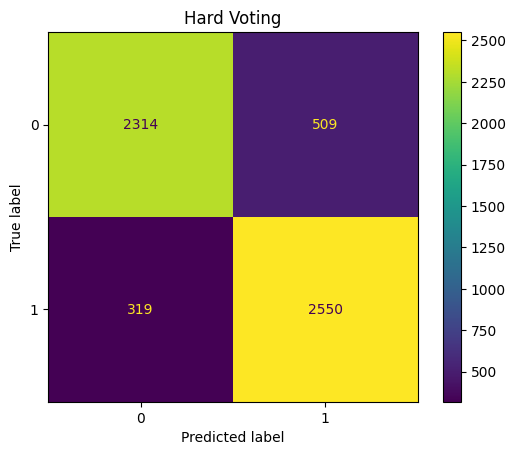

In [27]:
hard_conf_matrix = confusion_matrix(y_test, hard_results)
hard_conf_matrix_display = ConfusionMatrixDisplay(hard_conf_matrix)
hard_conf_matrix_display.plot()
plt.title("Hard Voting")
plt.show()

## Soft Voting

In [28]:
soft_results = soft_voting(X_test)

soft_results

array([[0.63176405, 0.36823595],
       [0.48560062, 0.51439938],
       [0.99263035, 0.00736966],
       ...,
       [0.75674968, 0.24325032],
       [0.05780327, 0.94219671],
       [0.99463084, 0.00536914]])

### Metrics

In [29]:
soft_results_discrete = np.argmax(soft_results, axis=1)

print(f"Accuracy: {accuracy_score(y_test, soft_results_discrete)}")
print(f"Recall: {recall_score(y_test, soft_results_discrete)}")
print(f"Precision: {precision_score(y_test, soft_results_discrete)}")
print(f"F1: {f1_score(y_test, soft_results_discrete)}")

Accuracy: 0.8545326774420239
Recall: 0.8936911815963751
Precision: 0.8305798509880142
F1: 0.8609805238415045


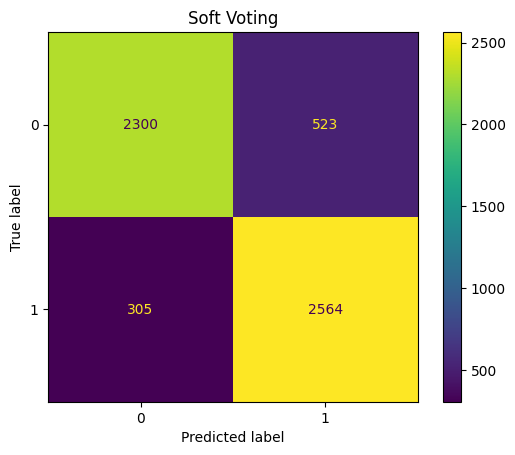

In [30]:
soft_conf_matrix = confusion_matrix(y_test, soft_results_discrete)
soft_conf_matrix_display = ConfusionMatrixDisplay(soft_conf_matrix)
soft_conf_matrix_display.plot()
plt.title("Soft Voting")
plt.show()

## Stacking

In [31]:
stacking_results = stacking(X_test)

stacking_results

array([[0.36213769, 0.63786231],
       [0.20860718, 0.79139282],
       [0.99805111, 0.00194889],
       ...,
       [0.99519543, 0.00480457],
       [0.01632897, 0.98367103],
       [0.9981204 , 0.0018796 ]])

### Metrics

In [32]:
stacking_results_discrete = np.argmax(stacking_results, axis=1)

print(f"Accuracy: {accuracy_score(y_test, stacking_results_discrete)}")
print(f"Recall: {recall_score(y_test, stacking_results_discrete)}")
print(f"Precision: {precision_score(y_test, stacking_results_discrete)}")
print(f"F1: {f1_score(y_test, stacking_results_discrete)}")

Accuracy: 0.8620871398453971
Recall: 0.8790519344719414
Precision: 0.852027027027027
F1: 0.8653285297649682


### Confusion Matrix

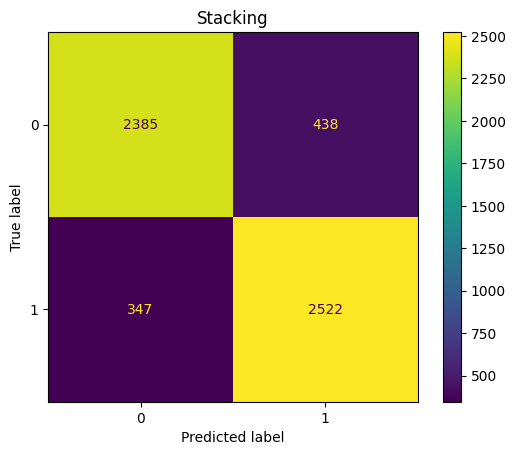

In [33]:
stacking_conf_matrix = confusion_matrix(y_test, stacking_results_discrete)
stacking_conf_matrix_display = ConfusionMatrixDisplay(stacking_conf_matrix)
stacking_conf_matrix_display.plot()
plt.title("Stacking")
plt.show()